# Notebook: Setting Alert Thresholds with Causal Inference

### Overview 

The goal is to demonstrate how metric thresholds can be improved using causal inference using the Python lib [tfp-causalimpact](https://github.com/google/tfp-causalimpact). 

### Package Requirements

In [337]:
!pip install -q tfp-causalimpact
!pip install -q tensorflow-probability[tf]
!pip install -q pydantic
!pip install -q scipy


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Module Imports

In [338]:
import datetime as dt
import typing as T

import causalimpact as ci
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pydantic as pdt

In [339]:
plt.ion()

### Utilities

In [340]:
class MockTsVariables(pdt.BaseModel):
    window: T.Annotated[
        int,
        """
        Specifies the duration for which the data should be generated. 
        This parameter defines the range of the time series, starting from end_date and going back by the specified duration.
        """
    ]
    observed_variable: T.Annotated[
        str,
        """
        Specifies the name of the column in the generated DataFrame that contains the metric values. 
        This allows you to define a custom label for the metric being analyzed. 
        For example, daily_denial_count.
        """
    ]
    frequency: T.Annotated[
        str,
        """
        The offset frequency.
        See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
        """
    ]
    outlier_variability: T.Annotated[
        T.Literal["low", "high"],
        """
        Specifies the magnitude of the outliers to control the severity of anomalies in the generated data.
        
        - "low": Generates outliers with smaller deviations from the typical range of values (e.g., multipliers between 1.5 and 2).
        - "high": Produces more extreme outliers with larger deviations (e.g., multipliers between 2 and 5).   
        """
    ] = "low"



def mock_ts_variables(params: MockTsVariables):    
    # Determine the start date or time based on the window
    start_date = dt.date.today() - pd.to_timedelta(params.window, unit=params.frequency[0].lower())

    # Generate the date range based on the frequency
    date_range = pd.date_range(start=start_date, end=dt.date.today(), freq=params.frequency)

    # Generate random metric values (Poisson distribution for count-like data)
    np.random.seed(42)
    daily_metrics = np.random.poisson(lam=50, size=len(date_range))

    # Adjust the variability of outliers
    if params.outlier_variability == 'low':
        multiplier_range = (1.5, 2)
    elif params.outlier_variability == 'high':
        multiplier_range = (2, 5)
    else:
        raise ValueError("outlier_variability must be either 'low' or 'high'")

    # Introduce outliers
    outlier_indices = np.random.choice(len(daily_metrics), size=int(len(daily_metrics) * 0.05), replace=False)
    multipliers = np.random.uniform(multiplier_range[0], multiplier_range[1], size=len(outlier_indices))
    daily_metrics[outlier_indices] = (daily_metrics[outlier_indices] * multipliers).astype(int)

    # Create the DataFrame
    df = pd.DataFrame({
        "date": date_range,
        params.observed_variable: daily_metrics
    })

    return df

#### Example 1 - Denial Metric

In [341]:

daily_metrics_df = mock_ts_variables(
    params=MockTsVariables(
        observed_variable="denial_count",
        window=365,
        frequency="D",
        outlier_variability="low"
    )
)

In [342]:
print(daily_metrics_df["denial_count"].describe())


count    366.000000
mean      50.931694
std       10.820743
min       29.000000
25%       44.250000
50%       50.000000
75%       55.000000
max      114.000000
Name: denial_count, dtype: float64


`count`: The total number of observations.

`mean`: The average value of the dataset

`std` (Standard Deviation): A measure of the spread or variability in the dataset. A higher value indicates more variability around the mean.

`min`: The smallest value in the dataset.

`25%` (1st Quartile): The value below which 25% of the data falls.

`50%` (Median): The middle value of the dataset.

`75%` (3rd Quartile): The value below which 75% of the data falls.

`max`: The largest value in the dataset.

<Axes: >

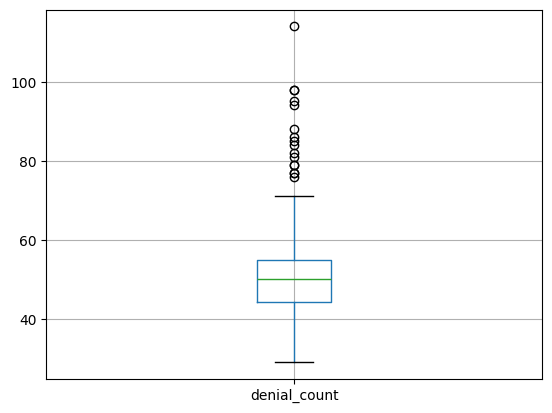

In [343]:
plt.ion()
daily_metrics_df.boxplot(
    column="denial_count", 
    grid=True, 
    return_type="axes"
)

<Axes: title={'center': 'Distribution of Daily Denial Count'}, ylabel='Frequency'>

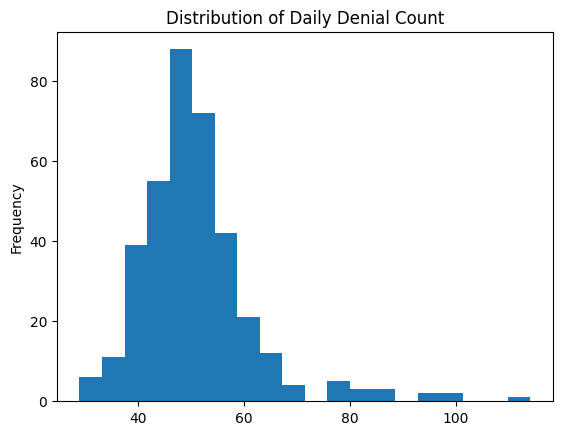

In [344]:
plt.ion()
daily_metrics_df["denial_count"].plot(
    kind="hist", 
    bins=20,
    title="Distribution of Daily Denial Count"
)

<Axes: title={'center': 'Daily Denial Count'}, xlabel='date'>

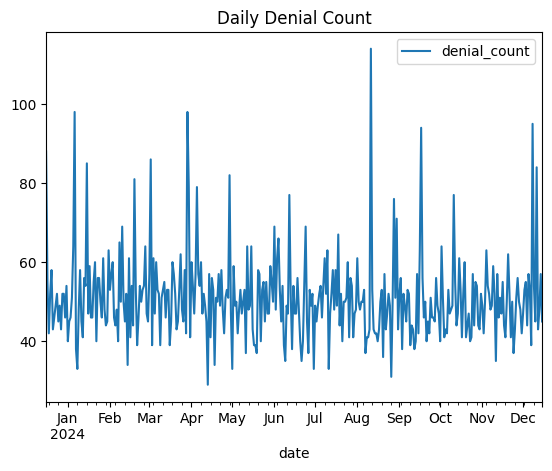

In [345]:
daily_metrics_df.plot(
    x="date", 
    y="denial_count", 
    kind="line", 
    title="Daily Denial Count"
)

### Using Interquartile Range (IQR) for Outlier Bounds

The Interquartile Range (IQR) is a measure of the middle 50% of a dataset, showing where the bulk of the values lie. It helps identify variability and outliers by capturing the range between the 25th percentile (Q1) and the 75th percentile (Q3), ignoring extreme values at the tails of the distribution.

In [346]:
from scipy.stats import skew

def get_dynamic_iqr_multiplier(data):
    """
    Determine the IQR multiplier dynamically based on skewness.
    
    The IQR multiplier is a factor used to define the range for identifying outliers in a dataset. 
    By multiplying the Interquartile Range (IQR) by a specific value (typically 1.5), you establish thresholds to 
    flag data points that are significantly different from the majority, providing detection of unusual values even when the data is skewed.    
    """
    # Calculate skewness
    data_skewness = skew(data, nan_policy='omit')

    # Adjust multiplier based on skewness
    if abs(data_skewness) < 0.5:  # Symmetrical
        multiplier = 1.5
    elif abs(data_skewness) < 1:  # Moderately skewed
        multiplier = 2.0
    else:  # Heavily skewed
        multiplier = 2.5

    return multiplier

In [347]:
iqr_example__daily_metrics_df = daily_metrics_df.copy()

In [348]:
MULTIPLIER = get_dynamic_iqr_multiplier(iqr_example__daily_metrics_df["denial_count"])

Q1 = iqr_example__daily_metrics_df["denial_count"].quantile(.25)
Q3 = iqr_example__daily_metrics_df["denial_count"].quantile(.75)

IQR = Q3 - Q1

LOWER_BOUND = Q1 - (MULTIPLIER * IQR)
UPPER_BOUND = Q3 + (MULTIPLIER * IQR)

iqr_example__daily_metrics_df["iqr_lower_bound"] = LOWER_BOUND
iqr_example__daily_metrics_df["iqr_upper_bound"] = UPPER_BOUND

print("The factor used to determine outliers based on how skewed data is", MULTIPLIER)
print("Q1: 25% of datapoints are below", Q1)
print("Q3: 75% of datapoints are below", Q3)
print("The spread/distance between 25% and 75% percentiles: ", IQR)
print("Any value lower is an outlier:", LOWER_BOUND)
print("Any value higher is an outlier:", UPPER_BOUND)

The factor used to determine outliers based on how skewed data is 2.5
Q1: 25% of datapoints are below 44.25
Q3: 75% of datapoints are below 55.0
The spread/distance between 25% and 75% percentiles:  10.75
Any value lower is an outlier: 17.375
Any value higher is an outlier: 81.875


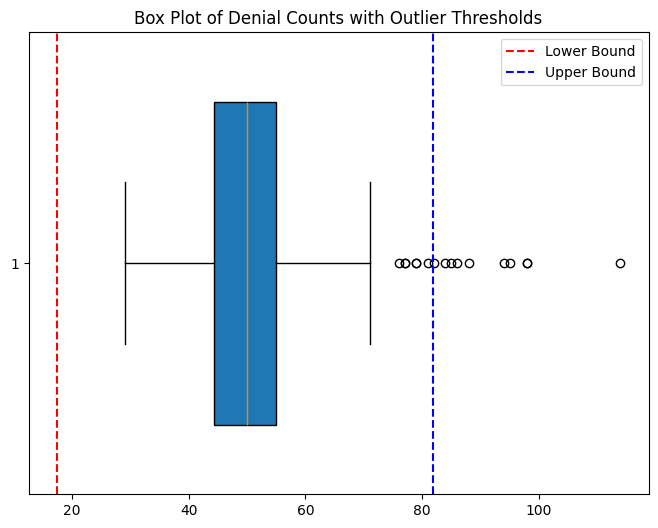

In [349]:
plt.figure(figsize=(8, 6))
plt.boxplot(iqr_example__daily_metrics_df['denial_count'], vert=False, patch_artist=True, widths=0.7)
plt.axvline(LOWER_BOUND, color='red', linestyle='--', label='Lower Bound')
plt.axvline(UPPER_BOUND, color='blue', linestyle='--', label='Upper Bound')
plt.title('Box Plot of Denial Counts with Outlier Thresholds')
plt.legend()
plt.show()

In [350]:
iqr_example__daily_metrics_df["is_outlier"] = (
    (iqr_example__daily_metrics_df["denial_count"] < LOWER_BOUND) | 
    (iqr_example__daily_metrics_df["denial_count"] > UPPER_BOUND)
)

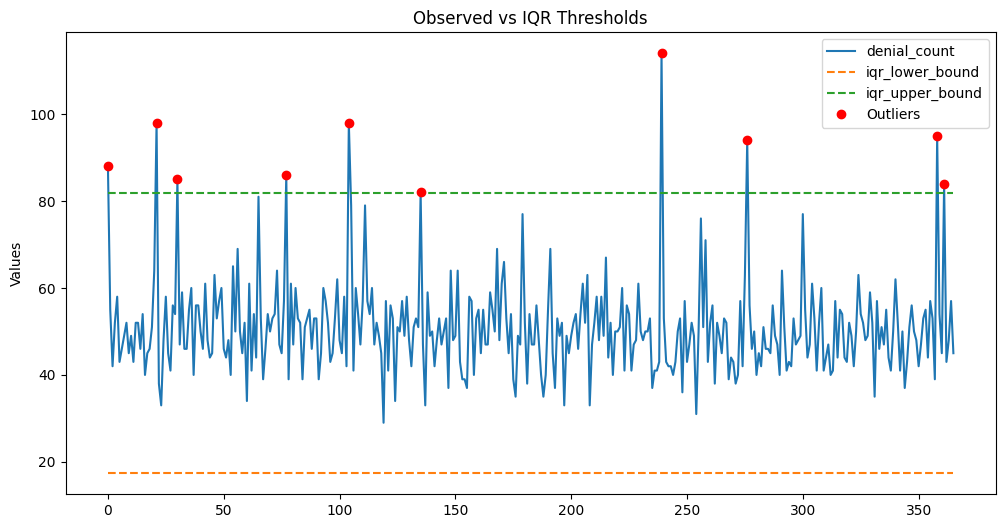

In [351]:
ax = iqr_example__daily_metrics_df.plot(
    y=["denial_count", "iqr_lower_bound", "iqr_upper_bound"],
    style=["-", "--", "--"],
    figsize=(12, 6),
    title="Observed vs IQR Thresholds",
    ylabel="Values"
)

iqr_example__daily_metrics_df[iqr_example__daily_metrics_df["is_outlier"]]["denial_count"].plot(
    ax=ax, 
    style="ro", 
    label="Outliers", 
    markersize=6
)

ax.legend()

- A little verbose but provides a quick way to get some reliable boundaries to identify outliers 
- Great for univariate datasets - for example clicks.
- Not totally intuitive for multi-variate datasets, for example clicks + impressions 
- Right now we are looking at the past year. But we'd narrow this down to a smaller window - for example 90 days. That that would increase the number of outliers in a given window because the bounds will change.


### Using Causal Inference

Causal inference at a 5000 foot level:
- Randomized sampling is the gold standard way to determine if an intervention on a treatment group has an effect. It ensures that unknown confounders impact the effect of the treated. Meaning regardless of the treatment, the unit would have no different of an outcome.
- It's not always easy to have clean control/treatment groups. Sometimes it's not possible at all. For example you can't detect the consequences of smoking by forcing a population to smoke. Causal Inference allows you to to measure the counterfactual (what would have happened in a different world)

##### Why can we use this?
The library takes a dataset with some observed unit (example clicks), as well as covariates (example impressions). 

It uses the index as a time series divided into two parts:
- `pre_period` - the data prior to a treatment/intervention. for example a new ad campaign.
- `post_period` - the data after a treatment/intervention.

It will model the pre-period data to understand the probability distributions of the dataset. So for day's total clicks, it will determine the associated probability of the total clicks for a given day.

It uses the pre-period (no intervention) to determine what the post-period counterfactual would be. The counterfactual is the world opposite of what happened - i.e. no intervention. 

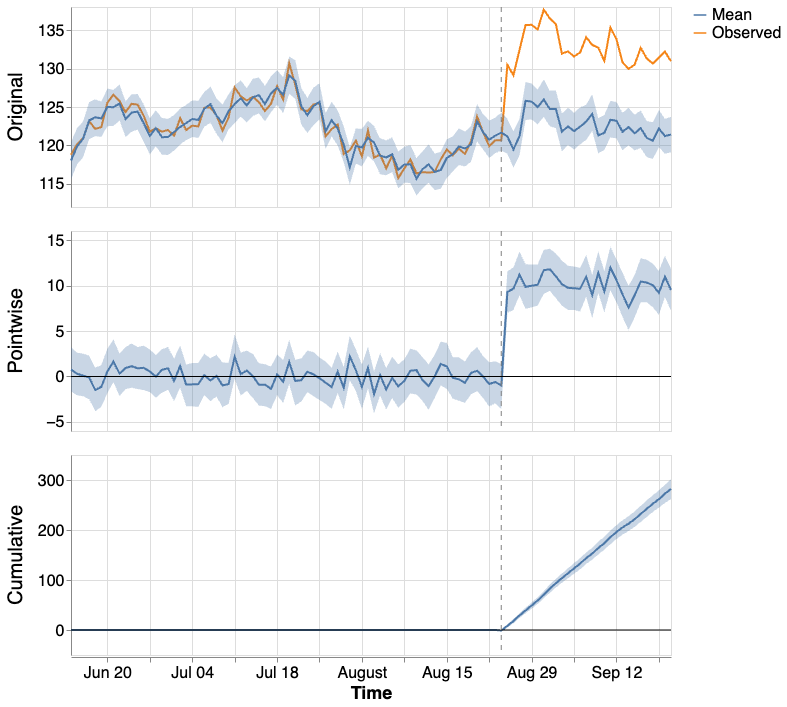

CausalImpact will produce the graph above as an output. The parts of this are:
- Observed vs predicted data: the observed data along with the model's predicted values. It shows how the data would have evolved if the intervention never happened. 
- Mean vs. observed. Observed is the actual value. Mean is the predicted value. 
- The shaded area is the 95% confidence interval around the predicted values. So it represents the range within we'd expect the true value to lie. * "A 95% confidence interval means that if we were to repeat the process of sampling and analysis numerous times, approximately 95% of the calculated intervals would contain the true population parameter. It's important to note that this does not imply that 95% of the observed data points fall within this interval. Instead, it reflects our confidence in the range where the true parameter lies."*
- If the observed data falls outside the 95% confidence interval of the predicted values, it suggests that the intervention may have had a statistically significant effect.
- Pointwise - the difference between the actual value and the predicted value. Example if the observed unit is 100 and the predicted is 105 the pointwise would be 5
- Cumulative - the sum of the pointwise differences. Can be used for measuring impact. Like ROI - so if the post period is say 10 days and your unit is clicks you can say you have X additional clicks because of some intervention (ad campaign)

##### Why is this useful for thresholds?
For threshold setting, we can use the univariate or multi-variate dataset to find the probabilities of the data. This enables us to find thresholds based on the probability distributions. 

In [352]:
ci_example__daily_metrics_df = daily_metrics_df.copy()

In [353]:
pre_period = [ci_example__daily_metrics_df["date"].min(), ci_example__daily_metrics_df["date"].max() - dt.timedelta(days=1)]
post_period = [ci_example__daily_metrics_df["date"].max() - dt.timedelta(days=0), ci_example__daily_metrics_df["date"].max()]

print(pre_period)
print(post_period)

[Timestamp('2023-12-16 00:00:00'), Timestamp('2024-12-14 00:00:00')]
[Timestamp('2024-12-15 00:00:00'), Timestamp('2024-12-15 00:00:00')]


In [354]:
impact = ci.fit_causalimpact(
    data=ci_example__daily_metrics_df.set_index("date"),
    pre_period=pre_period,
    post_period=post_period
)

#### summary table details


In [355]:
impact.summary

,actual,predicted,predicted_lower,predicted_upper,predicted_sd,abs_effect,abs_effect_lower,abs_effect_upper,abs_effect_sd,rel_effect,rel_effect_lower,rel_effect_upper,rel_effect_sd,p_value,alpha
average,45.0,50.574051,29.603659,71.977128,11.199624,-5.574051,-26.977128,15.396341,11.199624,-0.058934,-0.374801,0.520083,0.253639,0.322974,0.05
cumulative,45.0,50.574051,29.603659,71.977128,11.199624,-5.574051,-26.977128,15.396341,11.199624,-0.058934,-0.374801,0.520083,0.253639,0.322974,0.05


In [356]:
impact.series

,observed,posterior_mean,posterior_lower,posterior_upper,point_effects_mean,point_effects_lower,point_effects_upper,cumulative_effects_mean,cumulative_effects_lower,cumulative_effects_upper,pre_period_start,pre_period_end,post_period_start,post_period_end
date,,,,,,,,,,,,,,
2023-12-16,88,52.164104,30.693964,73.207600,35.835896,14.792400,57.306036,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-17,55,52.155346,29.196041,72.493847,2.844654,-17.493847,25.803959,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-18,42,52.150169,32.510952,72.872725,-10.150169,-30.872725,9.489048,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-19,52,52.143215,30.362404,71.771083,-0.143215,-19.771083,21.637596,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2023-12-20,58,52.144634,29.883593,73.039542,5.855366,-15.039542,28.116407,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11,84,50.584133,30.283135,71.669736,33.415867,12.330264,53.716865,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2024-12-12,43,50.582806,28.029975,68.948458,-7.582806,-25.948458,14.970025,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15
2024-12-13,48,50.584835,30.418469,72.258858,-2.584835,-24.258858,17.581531,0.000000,0.000000,0.000000,2023-12-16,2024-12-14,2024-12-15,2024-12-15


In [357]:
ci.plot(impact)

alt.FacetChart(...)

In [358]:
print(ci.summary(impact, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    45.0               45.0
Prediction (s.d.)         50.6 (11.2)        50.6 (11.2)
95% CI                    [29.6, 72.0]       [29.6, 72.0]

Absolute effect (s.d.)    -5.6 (11.2)        -5.6 (11.2)
95% CI                    [-27.0, 15.4]      [-27.0, 15.4]

Relative effect (s.d.)    -5.9% (25.4%)      -5.9% (25.0%)
95% CI                    [-37.5%, 52.0%]    [-37.5%, 52.0%]

Posterior tail-area probability p: 0.323
Posterior prob. of a causal effect: 67.70%

For more details run the command: summary(impact, output_format="report")


/Users/destefano/Desktop/poc-repos/notebooks/myenv/lib/python3.9/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


Actual
- Average: The mean value of the observed data during the post-intervention period. In our case the current day - what the actual value was.

Prediction (s.d.)
- Average: The mean predicted value (counterfactual) for the post-intervention. In our case the current day's prediction along with the standard deviation around the predicted value to represent uncertainty 

95% CI 
- The 95% confidence interval for the average predicted value, providing a range within which the true average prediction is expected to lie with 95% confidence. This represents our boundaries for detecting outliers. 


In [359]:
print(ci.summary(impact, output_format="report"))


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 45.0. In the absence of an
intervention, we would have expected an average response of 50.6.
The 95% interval of this counterfactual prediction is [29.6, 72.0].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -5.6 with a 95% interval of
[-27.0, 15.4]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 45.0.
Had the intervention not taken place, we would have expected
a sum of 50.6. The 95% interval of this prediction is [29.6, 72.0].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -5.9%. The 95%


/Users/destefano/Desktop/poc-repos/notebooks/myenv/lib/python3.9/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [360]:

impact.series['avg_predicted_lower'] = impact.summary["predicted_lower"].iloc[0]
impact.series['avg_predicted_upper'] = impact.summary["predicted_upper"].iloc[0]

impact.series["is_outlier"] = (
    (impact.series["observed"] < impact.series["avg_predicted_lower"]) | 
    (impact.series["observed"] > impact.series["avg_predicted_upper"])
)


In [361]:
result_df: pd.DataFrame = impact.series[[
    'observed', 
    'avg_predicted_lower', 
    'posterior_lower',
    'avg_predicted_upper',
    'posterior_upper',
    'is_outlier'
]].copy()

result_df.sort_index(inplace=True)


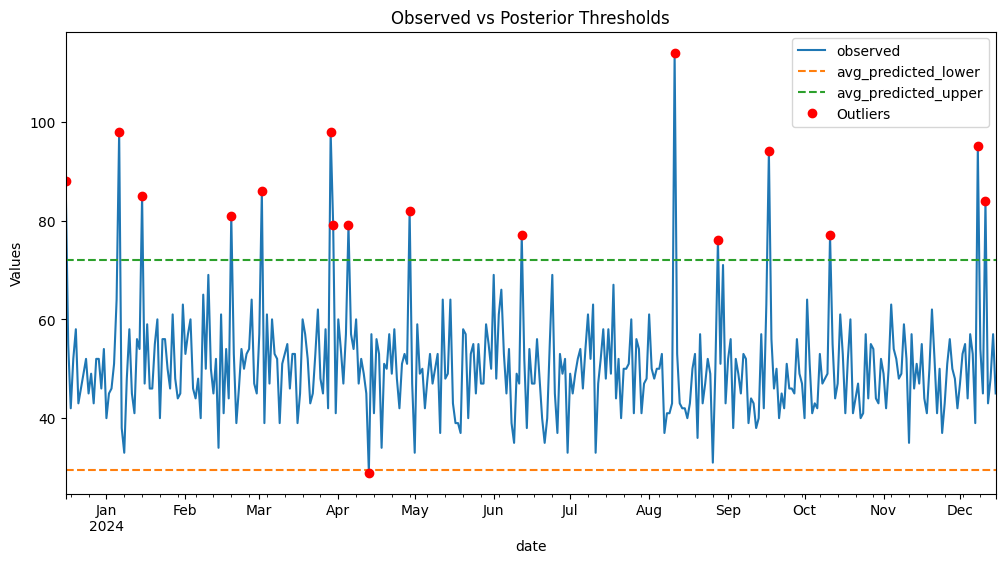

In [ ]:

ax = result_df.plot(
    y=["observed", "avg_predicted_lower", "avg_predicted_upper"],
    style=["-", "--", "--"],
    figsize=(12, 6),
    title="Observed vs Average Predicted Post Period Thresholds",
    ylabel="Values"
)

result_df[result_df["is_outlier"]]["observed"].plot(
    ax=ax, 
    style="ro", 
    label="Outliers", 
    markersize=6
)

ax.legend()

Here we were able to identify 6 more outliers than the IQR method. 

- This could be improved by adding to covariate values. For example, daily values such as `total_claims_processed`. These values would help improve the fitted model which would narrow the intervals we see because it's making better predictions. 
- Example of unit + covariates would say maybe a spike in clicks was the result in more impressions (CTR is roughly the same). The CTR could also be the observed value. 
- The wider intervals indicate a lack of confidence, which contributes to why we have an statistically insignificant p-value


Other usecases for this 
- Data drift. For example the distributions or total predicted values (ex. total predicted denial)
- Trained model performance. For example, releasing version 2 of a model - did performance increase on given metrics? 